In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numba import jit
%matplotlib inline

Pi = np.pi

The first example of a fractal we will run into is the Weierstrass function which is given by
$$
f(x;a,b) = \sum_{k=0}^{\infty} a^{k}\cos(b^{k}\pi x), ~ 0<a<1, ~ ab > 1 + \frac{3\pi}{2}
$$

In [2]:
def wfunc(x,a,b,tol):
    xp = x*Pi
    tot = np.cos(xp)
    term = 1.
    aval = 1.
    bval = 1.
    while(abs(term)>=tol):
        aval *= a
        bval *= b
        term = aval*np.cos(bval*xp)
        tot += term
    return tot

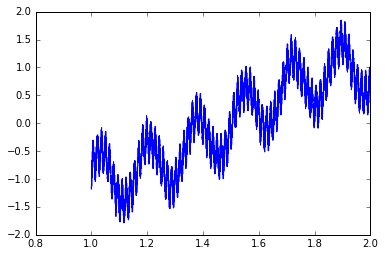

In [3]:
xvals = np.linspace(1,2,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

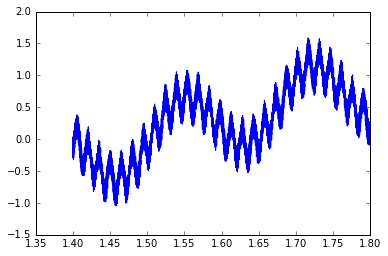

In [4]:
xvals = np.linspace(1.4,1.8,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

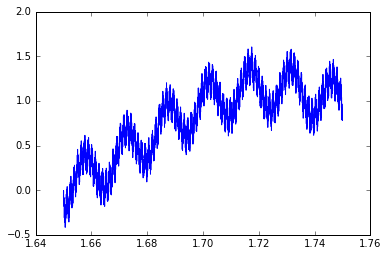

In [5]:
xvals = np.linspace(1.65,1.75,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

In [6]:
def k_plot(P,Q,ptsx,ptsy,nlev):
    if nlev > 0:
        
        d = Q - P
        dperp = np.array([-d[1],d[0]])
        A = P + d/3.
        B = (P+Q)/2. + dperp/(2.*np.sqrt(3))
        C = P + 2.*d/3.
        
        indsx = [ii for ii,x in enumerate(ptsx) if x==Q[0]]
        indsy = [jj for jj,y in enumerate(ptsy) if y==Q[1]]
        
        if len(indsx)<len(indsy):
            mnln,mxln = len(indsx),len(indsy)
            sind,lind = indsx,indsy
        else:
            mnln,mxln = len(indsy),len(indsx)
            sind,lind = indsy,indsx
            
        for jj in range(mxln):
            for kk in range(mnln):
                if sind[kk]==lind[jj]:
                    ind = lind[jj]
                    break
        
        ptsx.insert(ind,C[0])
        ptsx.insert(ind,B[0])
        ptsx.insert(ind,A[0])
        
        ptsy.insert(ind,C[1])
        ptsy.insert(ind,B[1])
        ptsy.insert(ind,A[1])
        
        k_plot(P,A,ptsx,ptsy,nlev-1)
        k_plot(A,B,ptsx,ptsy,nlev-1)
        k_plot(B,C,ptsx,ptsy,nlev-1)
        k_plot(C,Q,ptsx,ptsy,nlev-1)    

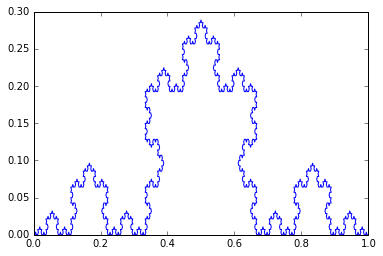

In [7]:
P = np.array([0.,0.])
Q = np.array([1.,0.])
ptsx = [0.,1.]
ptsy = [0.,0.]
k_plot(P,Q,ptsx,ptsy,5)
plt.plot(ptsx,ptsy)

*The Sierpinski Triangle*  So this is in some ways almost more straightforward than the Koch curve.  Start with an equilateral triangle.  Label its vertices as $A$, $B$, and $C$.  Between the midpoints of the vertices, draw another triangle.  Repeat this process on the three, smaller surounding triangles introduced by drawing the second, interior triangle.  

In [8]:
def sierp(A,B,C,n):
    
    if n>=1:
    
        plt.plot([A[0],B[0]],[A[1],B[1]],color='k')
        plt.plot([B[0],C[0]],[B[1],C[1]],color='k')
        plt.plot([C[0],A[0]],[C[1],A[1]],color='k')
        
        AB = (A+B)/2.
        BC = (B+C)/2.
        AC = (A+C)/2.
         
        sierp(A,AB,AC,n-1)
        sierp(AB,B,BC,n-1)
        sierp(AC,BC,C,n-1)

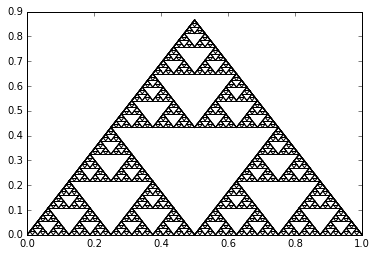

In [9]:
A = np.array([.5,np.sqrt(3)/2])
B = np.array([0.,0.])
C = np.array([1.,0.])
sierp(A,B,C,7)


*The Julia Set* First, let's talk about the complex plane $\mathbb{C}$, by which we mean the set of points $z$ where

$$
z = x + iy, ~ i=\sqrt{-1}
$$

and $x$ and $y$ are real.  We can talk about the magnitude of a complex number $|z|$ where we define this to be

$$
|z| = (z_{r}^{2}+z_{i}^{2})^{1/2}
$$

Don't let the notation push you around.  This is just Pythagoras theorem, or vector length in the plane and nothing more.  

Once we have these definitions in place, things more or less work the same way as you are used to on the real line, though you have to do more work usually.  For example, we have that 

$$
z^{2} = (x+iy)^{2} = x^{2}+2ixy+i^2y^2 = x^{2}-y^{2} + 2ixy
$$

We can therefore readily see that the map $f(z) = z^{2}$ maps the complex plane into the complex plane i.e.

$$
f : \mathbb{C} \rightarrow \mathbb{C}.
$$

We can then talk about families of maps such as

$$
f_{c}(z) = z^{2} + c,~ c = c_{r} + ic_{i}
$$

and to tie it in with everything we have been talking about, we can now look at complex discrete dynamical systems of the form 

$$
z_{n+1} = f_{c}(z_{n}), 
$$

So, we can now start asking some funny sorts of questions.  For example, what values of $c$ will make the sequence starting from $z_{0}=0$ remain bounded, i.e. can we describe the set

$$
J_{0} = \left\{c\in\mathbb{C} : \left|f_{c}(z_{n})\right|\leq M, ~ n>0,~z_{0}=0\right\}
$$

This is not a trivial question.  Let's see why.  If $z_{0}=0$, we then have 

$$
z_{1} = c, ~ z_{2} = c^{2} + c, ~ z_{3} = (c^{2}+c)^{2} + c, \cdots
$$

So sure, you could figure out a pattern, but it is going to be a mess.  As we will shortly see, while not necessarily hot, it is a beautiful mess indeed.  

In [19]:
@jit
def fmap(z,c):
    return z**2 + c

@jit
def jset(Xl,Xr,Yt,Yb,M,miter,Nvals):
    Xaxis = np.linspace(Xl,Xr,Nvals)
    Yaxis = np.linspace(Yb,Yt,Nvals)
    
    zpts = np.zeros([Nvals,Nvals])
    
    for jj in range(Nvals):
        for kk in range(Nvals):
            cval = Xaxis[jj] + 1j*Yaxis[kk]
            zval = cval
            cnt = 0
           
            while cnt < miter:
                zval = fmap(zval,cval)
                if(np.abs(zval)>M): break
                cnt += 1
            zpts[jj,kk] = cnt
                
    dpi = 72
    width = 10
    height = 10
    img_width = dpi * width
    img_height = dpi * height
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    ticks = np.arange(0,img_width,3*dpi)
    x_ticks = Xl + (Xr-Xl)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = Yb + (Yt-Yb)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    ax.imshow(zpts.T,origin='lower') 

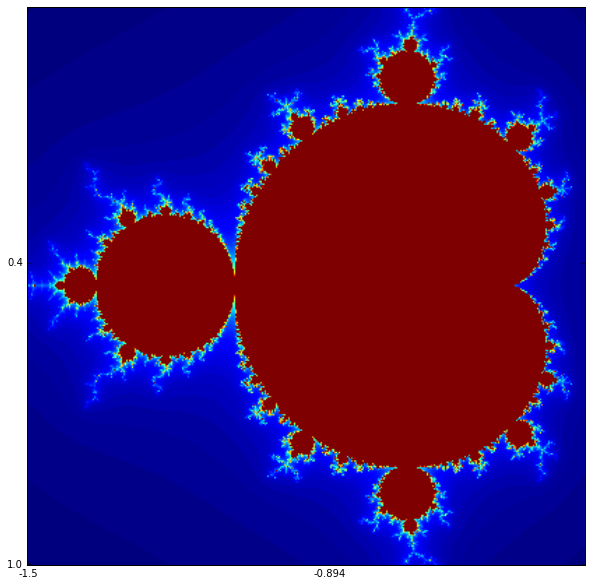

In [21]:
jset(-1.5,.52,-1.,1.,1e2,1e2,400)